<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/ESAA_Week2_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-1 ESAA 5기 김혜준 개념 필사 - 0318(금) 2주차 과제
 
## <핸즈온 머신러닝>
## Chapter 4 모델 훈련

### 4.1 선형 회귀
* 선형 모델 : 입력 특성의 가중치 합과 편향(절편)을 더해 예측 생성

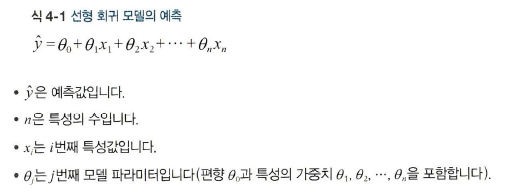

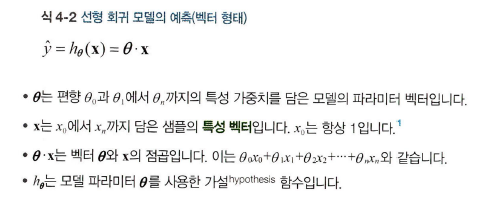

* 모델 훈련의 의미 : 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정
* RMSE(평균 제곱근 오차): 회귀에 가장 널리 사용되는 성능 측정 지표

  => 선형 회귀 모델을 훈련시키려면 RMSE를 최소화하는 $\theta$를 찾아야 함
  - MSE(평균 제곱 오차) 이용하면 같은 결과를 더 간단히 도출 가능
  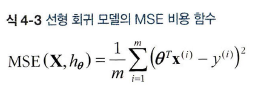


#### 4.1.1 정규방정식
* 비용 함수를 최소화하는 $\theta$ 값을 찾기 위한 해석적인 방법 (수학 공식)
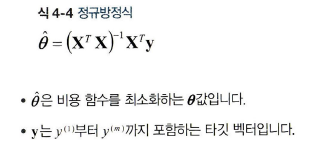

In [42]:
# 선형처럼 보이는 데이터 생성
import numpy as np

X = 2 * np.random.rand(100, 1) # 균일분포
y = 4 + 3 * X + np.random.randn(100, 1) # 가우시안 표준 정규 분포

In [43]:
# 정규방정식으로 θhat 계산
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) 
# np.linalg : 넘파이 선형대수 모듈
# inv() : 역행렬 계산
# dot() : 행렬 곱셈 수행

In [44]:
# 계산한 값 확인
theta_best

array([[3.61308771],
       [3.35788041]])

* 데이터 생성 시 사용한 함수 : $ y = 4 + 3x_1 + 가우시안잡음 $
* 계산 결과 : $\theta_0 = 4.251$, $\theta_1 = 2.770$

  => 잡음 때문에 원래 함수의 파라미터 $\theta_0 = 4$, $\theta_1 = 3$를 정확하게 재현하지 못함

* $ \hat{y} = X\hat{\theta} $

In [45]:
# θhat을 사용해 예측
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new] # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.61308771],
       [10.32884852]])

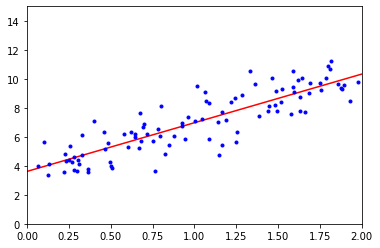

In [46]:
# 모델 예측 그래프에 표현
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [47]:
# 사이킷런에서 선형 회귀 수행
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.61308771]), array([[3.35788041]]))

In [48]:
lin_reg.predict(X_new)

array([[ 3.61308771],
       [10.32884852]])

* LinearRegression 클래스 : scipy.linalg.lstsq() (최소 제곱) 함수 기반

In [49]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.61308771],
       [3.35788041]])

* 위의 결과 : $ \hat{\theta} = X^+y $
  - $ X^+ $ : X의 유사역행렬(무어-펜로즈 역행렬) -> np.linalg.pinv()

In [50]:
# 유사역행렬
np.linalg.pinv(X_b).dot(y)

array([[3.61308771],
       [3.35788041]])

* 유사역행렬 : 특잇값 분해(singular value decomposition, SVD) 표준 행렬 분해 기법 사용해 계산
  - 정규방정식보다 효율적
  - 극단적인 경우도 처리 가능
    - m < n, 특성 중복 존재 
    
      -> 행렬 XTX의 역행렬 존재 X
    
      -> 정규방정식 X / 유사역행렬 O

#### 4.1.2 계산 복잡도
* 정규방정식 : (n + 1) * (n + 1) 크기가 되는 XTX의 역행렬 계산
* LinearRegression 클래스 SVD 방법의 계산 복잡도 : $ O(n^2) $ 
  
  => 특성 수 두 배 -> 계산 시간 약 4배 증가
* 학습된 선형 회귀 모델은 예측이 매우 빠름 -> 예측 계산 복잡도는 샘플 수와 특성 수에 선형적
  
  => 샘플이나 특성 수 두 배 -> 소요 시간 두 배 증가

### 4.2 경사 하강법
* 경사 하강법(gradient descent, GD) : 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정하여 여러 종류의 문제에서 최적의 해법을 찾는 일반적인 최적화 알고리즘

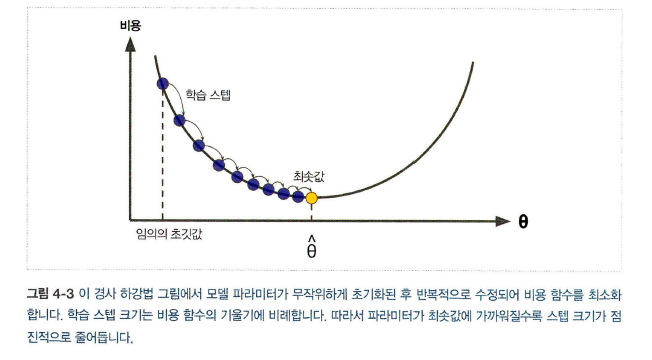


* 학습률(learning rate) : 스텝의 크기 결정
  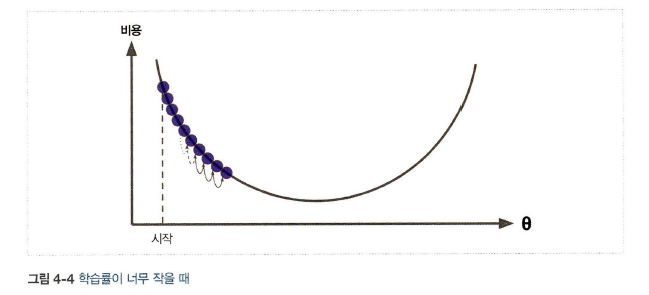

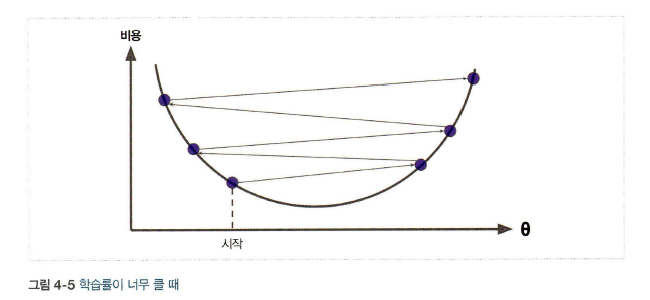

- 학습률 ↓ -> 시간 ↑
- 학습률 ↑ -> 알고리즘이 더 큰 값으로 발산

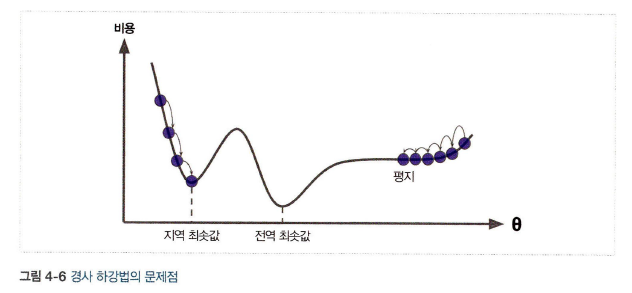

* 선형 회귀를 위한 MSE 비용 함수는 볼록 함수
  - 지역 최솟값이 없고, 하나의 전역 최솟값만 존재
  - 연속 함수이고 기울기 변화 없음

  => 경사 하강법이 전역 최솟값에 가깝게 접근할 수 있음

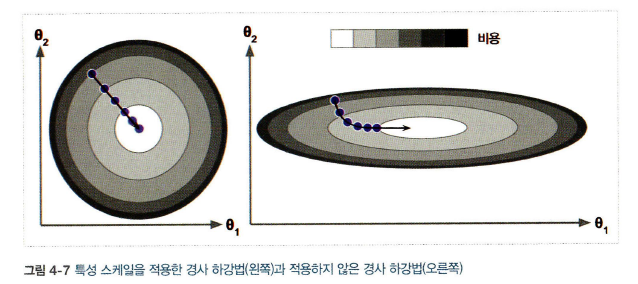

* 특성 1과 특성 2의 스케일이 같은 훈련 세트(왼쪽): 최솟값에 빠르게 도달
* 특성 1이 특성 2보다 더 작은 훈련 세트(오른쪽): 최솟값에 느리게 도달

=> 경사 하강법을 사용할 때에는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 함

* 모델 훈련 : 모델의 파라미터 공간에서 비용 함수를 최소화하는 모델 파라미터의 조합을 찾는 일 

#### 4.2.1 배치 경사 하강법
* 편도함수(partial derivative) : $\theta_j$가 조금 변경될 때, 비용 함수가 얼마나 바뀌는지 계산
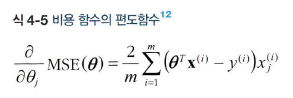
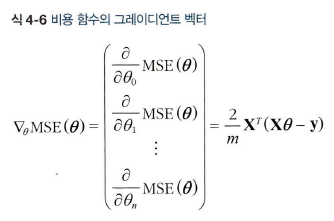

* 배치 경사 하강법(batch gradient descent) : 매 스텝에서 훈련 데이터 전체를 사용

  - 매우 큰 훈련 세트에서는 아주 느림
  - 경사 하강법은 특성 수에 민감하지 않아서 수십만 개의 특성에서 선형 회귀를 훈련시킬 때는 정규방정식이나 SVD 분해보다 빠름

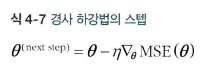

In [51]:
# 스텝 구하는 알고리즘 구현
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [52]:
# 계산된 theta 확인
theta # 정규방정식으로 찾은 것과 동일

array([[3.61308771],
       [3.35788041]])

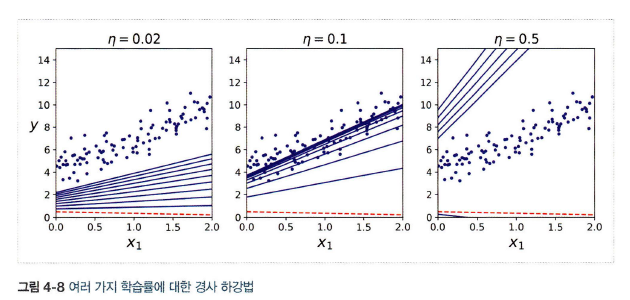

* 왼쪽 : 학습률 너무 낮음 -> 시간 오래 소요
* 가운데 : 학습률 적당 -> 반복 몇 번 만에 이미 최적점에 수렴 
* 오른쪽 : 학습률 너무 높음 -> 발산

=> 적절한 학습률을 찾기 위해 그리드 탐색 사용
  - 수렴하는데 너무 오래 걸리는 모델을 막기 위해 반복 횟수 제한 필요
    - 반복 횟수를 아주 크게 지정 -> 그래디언트 벡터가 아주 작아지면 즉, 벡터의 노름이 허용 오차 ϵ 보다 작아지면 알고리즘 중지
  - 수렴율 : ϵ 범위 안에서 최적의 솔루션에 도달하기 위해서는 O(1/ϵ) 반복

#### 4.2.2 확률적 경사 하강법
* 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그래디언트를 계산
  
  <장점>
  - 알고리즘 훨씬 빠름
  - 매 박복에서 하나의 샘플만 메모리에 있으면 됨 -> 매우 큰 훈련 세트도 훈련 가능
  - 비용 함수가 불규칙할 경우에는 지역 최솟값을 건너 뛸 수 있는 확률적 경사 하강법이 배치 경사 하강법보다 전역 최솟값을 찾을 가능성이 높음
  
  <단점>
  - 확률적(즉, 무작위)이기 때문에 배치 경사 하강법보다 훨씬 불안정
    - 비용 함수가 최솟값에 다다를 때까지 위아래로 요동치며 평균적으로 감소 -> 최솟값에 안착하지 못함 => 최적치 X

* 무작위성 : 지역 최솟값에서 탈출시키나 전역 최솟값에는 다다르지 못함

  - 학습률을 점진적으로 감소시켜 문제 해결
    - 담금질 기법 알고리즘과 유사
  - 학습 스케줄(learning schedule) : 매 반복에서 학습률을 결정하는 함수

  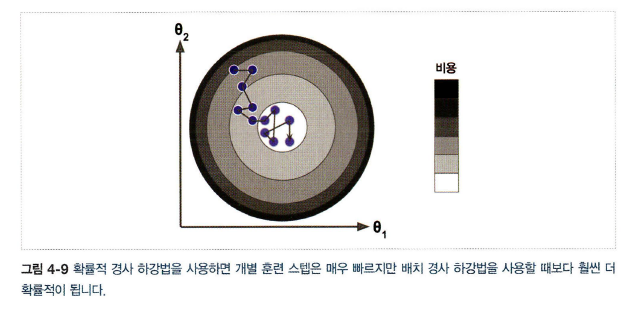

In [53]:
# 간단한 학습 스케줄을 사용한 확률적 경사 하강법 구현
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터 

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m): # m : 훈련 세트에 있는 샘플 수
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [54]:
# 계산된 theta 값 확인
theta 
# 배치 경사 하강법 코드가 전체 훈련 세트에 대해 1,000번 반복하는 동안 훈련 세트에서 50번만 반복하고도 매우 좋은 값에 도달함

array([[3.58947277],
       [3.33384263]])

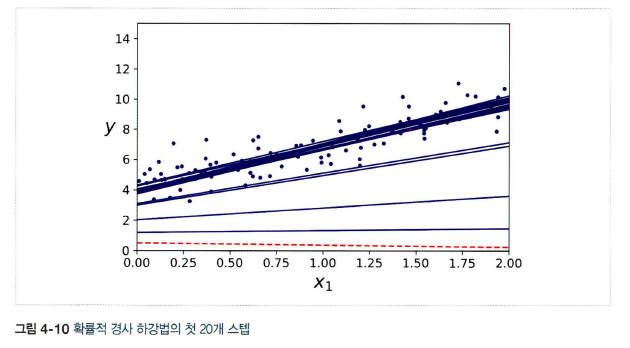

* 샘플을 무작위로 선택 -> 어떤 샘플은 한 에포크에서 여러 번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못할 수도 있음
  - 에포크마다 모든 샘플을 사용하려면 훈련 세트를 섞은 후 차례대로 하나씩 선택 -> 다음 에포크에서 다시 섞는 방법 활요 => 더 늦게 수렴

* SGDRegressor 클래스 : 사이킷런에서 SGD 방식으로 선형 회귀 사용하는 클래스, 기본값으로 제곱 오차 비용 함수를 최적화

In [55]:
# SGDRegressor 클래스
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
# max_iter=1000 : 최대 1000번 에포크 동안 실행
# tol=1e-3 : 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행
# eta0=0.1 : 학습률 0.1
# penalty=None : 규제 사용 안함
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [56]:
sgd_reg.intercept_, sgd_reg.coef_ # 정규방정식으로 구한 것과 매우 비슷한 값

(array([3.63852456]), array([3.41549885]))

#### 4.2.3 미니배치 경사 하강법
* 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그래디언트 계산
* 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용하여 확률적 경사 하강법에 비해 성능 향상
* 미니배치를 어느 정도 크게 하면 파라미터 공간에서 SGD보다 덜 불규칙하게 움직임
  - SGD보다 최솟값에 더 가까이 도달
  - 지역 최솟값에서 빠져나오기는 더 힘듦

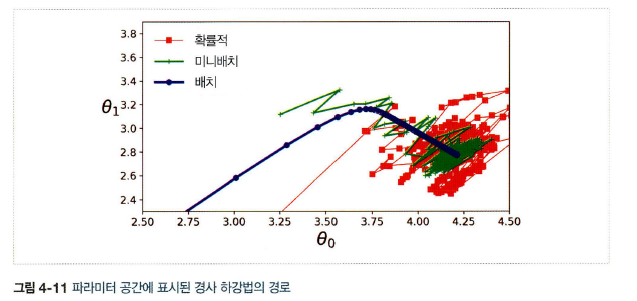

* 모두 최솟값 근처에 도달
  - 배치 경사 하강법의 경로는 실제 최솟값에서 멈춤
    - 매 스텝 많은 시간 소요
  - 확률적 경사 하강법, 미니배치 경사 하강법은 근처에서 맴돌고 있음
    - 적절한 학습 스케줄 사용 -> 최솟값에 도달


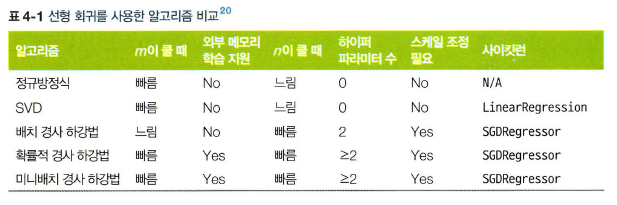
* 훈련 결과에 거의 차이 없음
* m : 훈련 샘플 수 / n : 특성 수

### 4.3 다항 회귀
* 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 기법

In [69]:
# 2차방정식으로 비선형 데이터 생성
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

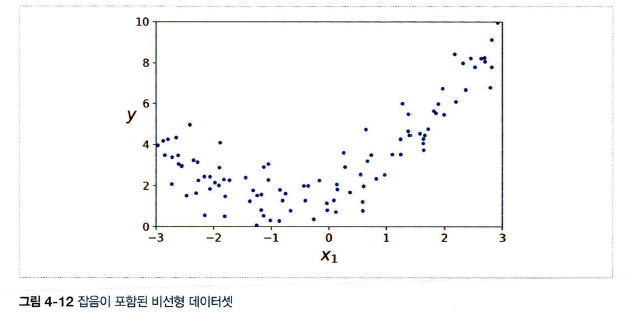

In [71]:
# 사이킷런의 PolynomialFeatures를 사용해 훈련 데이터 변환
from sklearn.preprocessing import PolynomialFeatures
# 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가
poly_features = PolynomialFeatures(degree=2, include_bias=False) 
X_poly = poly_features.fit_transform(X)
X[0]

array([-1.26335463])

In [72]:
X_poly[0] # 원래 특성 X와 이 특성의 제곱을 포함

array([-1.26335463,  1.59606492])

In [73]:
# 확장된 훈련 데이터에 LinearRegression 적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.43270564]), array([[0.98822635, 0.40918165]]))

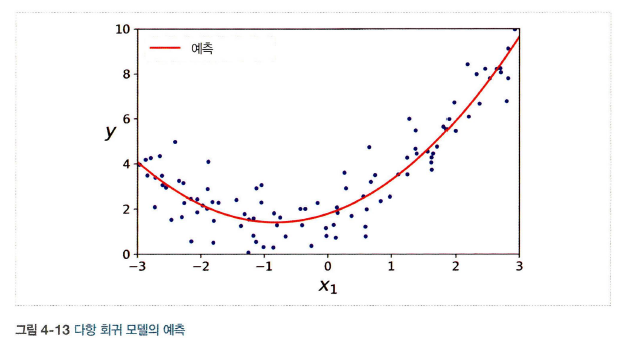

* 특성이 여러 개일 때 다항 회귀는 특성 사이의 관계를 찾을 수 있음
  - PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문

### 4.4 학습 곡선
* 고차 다항 회귀를 적용 -> 보통의 선형 회귀보다 훨씬 더 훈련 데이터에 잘 맞춤
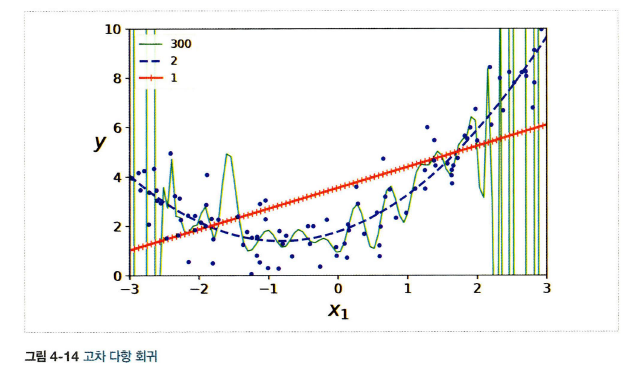

<교차 검증>
* 과대적합 : 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁜 경우 -> 모델이 너무 복잡
  - 고차 다항 회귀 모델
* 과소적합 : 양쪽 모두 좋지 않은 경우 -> 모델이 너무 단순
  - 선형 모델 
* 가장 일반화가 잘될 모델
  - 2차 다항 회귀

* 학습 곡선 : 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기 (또는 훈련 반복)의 함수로 표현
  - 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러번 훈련


In [74]:
# 주어진 훈련 데이터에서 모델의 학습 곡선을 그리는 함수 정의
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [],[]
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label="훈련 세트")
  plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label="검증 세트")

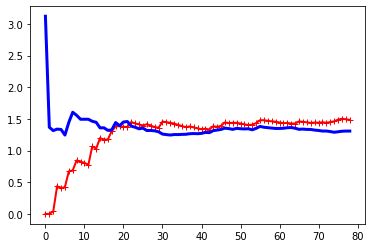

In [75]:
# 단순 선형 회귀 모델(직선)의 학습 곡선
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

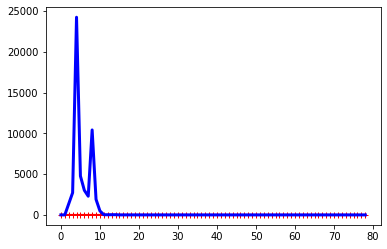

In [76]:
# 같은 데이터의 10차 다항 회귀 모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)

### 4.5 규제가 있는 선형 모델
#### 4.5.1 릿지 회귀
* 규제가 추가된 선형 회귀 버전
* 모델의 가중치가 가능한 한 작게 유지되도록 노력
* 규제항은 훈련하는 동안에만 비용 함수에 추가, 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가

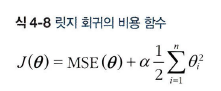

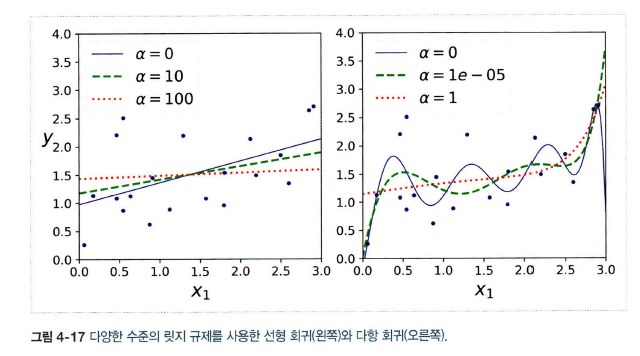

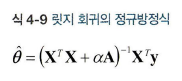

In [77]:
# 사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.20945589]])

In [78]:
# 확률적 경사 하강법 사용
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.18132267])

#### 4.5.2 라쏘 회귀
* 선형 회귀의 또 다른 규제된 버전
* 릿지 회귀처럼 비용 함수에 규제항을 더하지만 $ l_2$ 노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 $ l_1$ 노름을 사용

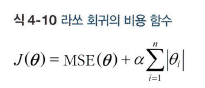

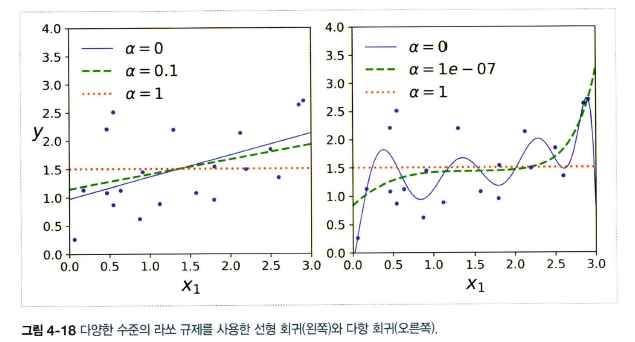

* 덜 중요한 특성의 가중치를 제거
* 자동으로 특성 선택으로 하고 희소 모델을 생성
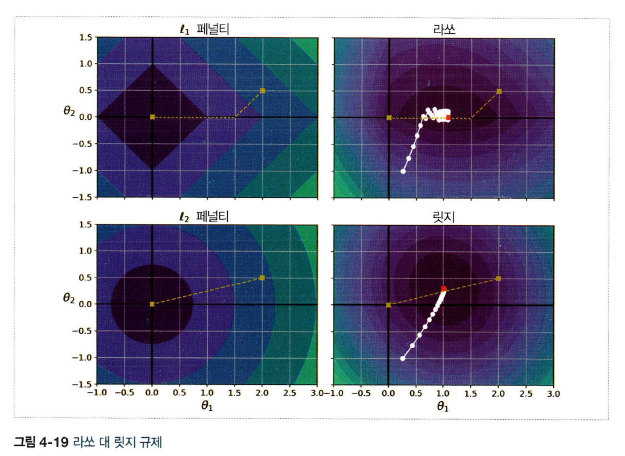

* 라쏘의 비용 함수는 $\theta_i = 0 (i = 1,2,...,n)$일때 미분 불가능
  => 서브그래디언트 벡터 g  사용

  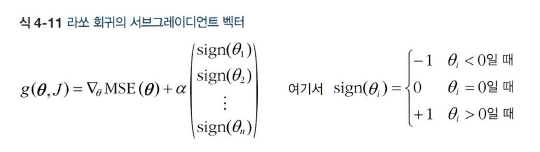

In [79]:
# Lasso 클래스
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([5.16738387])

#### 4.5.3 엘라스틱넷
* 릿지 회귀와 라쏘 회귀를 절충한 모델
* 규제항 : 릿지와 회귀의 규제항의 합
* 혼합 정도 : 혼합 비율 r
  - r = 0 : 엘라스틱넷 = 릿지 회귀
  - r = 1 : 엘라스틱넷 = 라쏘 회귀

  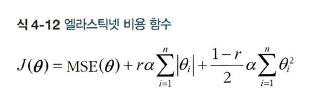

* 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때 선호

In [80]:
# ElasticNet 클래스 사용 예제
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) # 혼합 비율 r = 0.5
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.16737091])

#### 4.5.4 조기 종료
* 검증 에러가 최솟값에 도달하면 바로 훈련을 중지
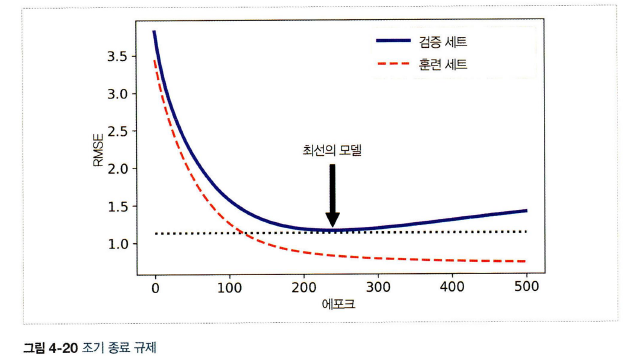


In [83]:
# 조기 종료 구현 코드
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5)

# 데이터 준비
poly_scaler = Pipeline([
                        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
                        ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) # 훈련을 이어서 진행합니다.
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

### 4.6 로지스틱 회귀
* 샘플이 특정 클래스에 속할 확률을 추정하는데 사용
  - 이진 분류기
      - 추정 확률 50% 넘으면 양성 클래스
      - 그렇지 않으면 음성 클래스

#### 4.6.1 확률 추정
* 입력 특성의 가중치 값 계산

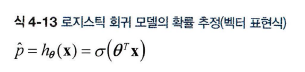

-> 결괏값의 로지스틱(0과 1 사이의 값을 출력하는 시그모이드 함수) 출력

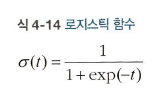

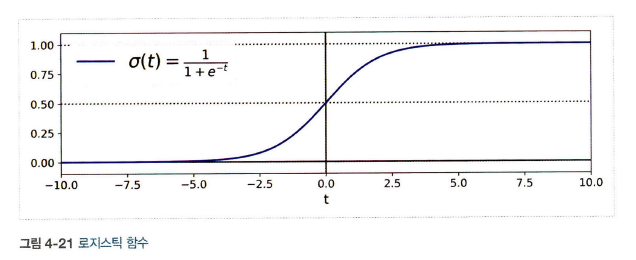

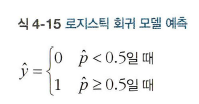

#### 4.6.2 훈련과 비용 함수
* 훈련 목적
  - 양성 샘플에 대헤서는 높은 확률을 추정
  
  - 음성 샘플에 대해서는 낮은 확률을 추정
  
  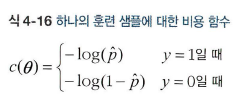

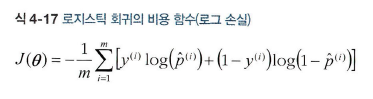

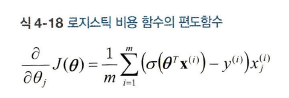

#### 4.6.3 결정 경계
* 붓꽃 데이터셋을 사용

In [84]:
# 붓꽃 데이터 로드
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [85]:
X = iris["data"][:, 3:]  # 꽃잎의 너비
y = (iris["target"] == 2).astype(np.int)  # Iris-virginica면 1, 그렇지 않으면 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [86]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

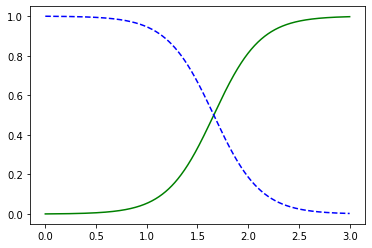

In [87]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

In [89]:
log_reg.predict([[1.7], [1.5]]) # 꽃잎 너비가 1.6cm보다 크면 Iris-Verginica, 그보다 작으면 아니라고 예측

array([1, 0])

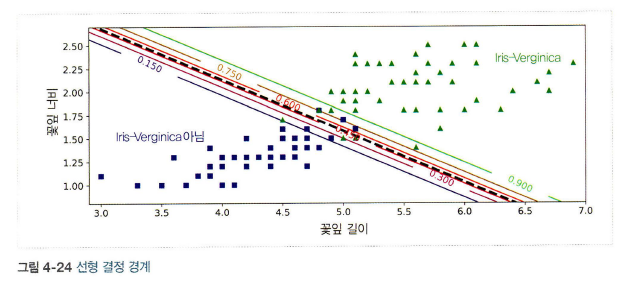

* 로지스틱 회귀 $l_1, l_2$ 페널티 사용하여 규제 가능

  => 사이킷런은 $l_2$ 페널티가 기본

#### 4.6.4 소프트맥스 회귀
* 로지스틱 회귀 모델은 직접 다중 클래스를 지원 -> 소프트맥스 함수 적용


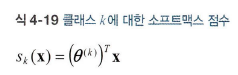

* 각 클래스는 자신만의 파라미터 벡터 $\theta^{(k)}$가 존재

  => 파라미터 행렬에 행으로 저장

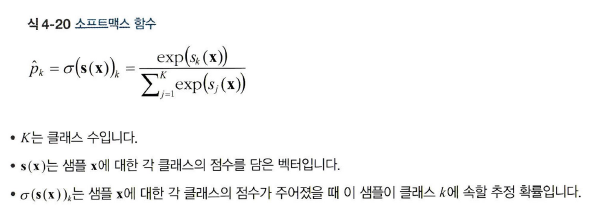

* 추정 확률이 가장 높은 클래스 선택
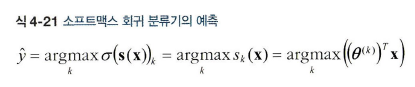

* 크로스 엔트로피 비용 함수를 최소화
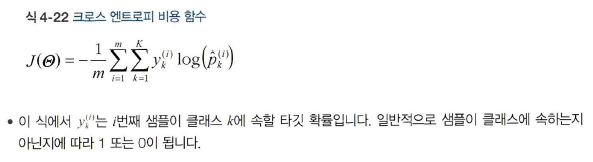

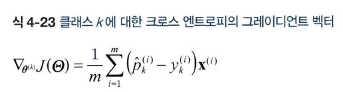


In [90]:
# 소프트맥스 회귀를 사용해 붓꽃 분류
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10) # 소프트회귀 사용위한 파라미터 설정 수행
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [91]:
softmax_reg.predict([[5, 2]]) # Iris-Virginica

array([2])

In [92]:
softmax_reg.predict_proba([[5, 2]]) # 5.8% 확률로 Iris-Versicolor

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

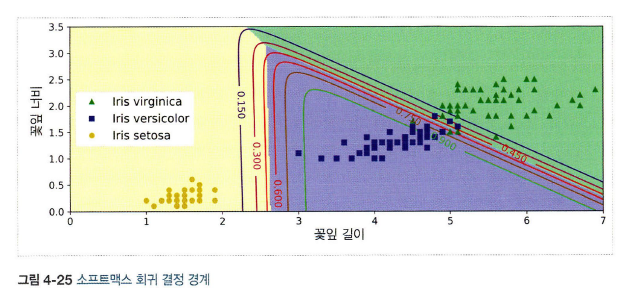